In [ ]:
import numpy as np
from scipy.linalg import toeplitz

def build_convolution_matrix(kernel, input_length):
    """
    kernel: h, 1D array of length M
    input_length: N, the length of output y
    returns: H, convolution matrix of shape (N, M+N-1)
    """
    M = len(kernel)
    N = input_length
    padded_h = np.pad(kernel, (0, N - 1), 'constant')  # length M+N-1
    first_col = np.concatenate(([kernel[0]], np.zeros(N - 1)))
    H = toeplitz(first_col, padded_h)
    return H


def deconvolve_via_pinv(y, h, delta=1e-3):
    H = build_convolution_matrix(h, len(y))
    HtH = H.T @ H
    regularized_inverse = np.linalg.inv(HtH + delta * np.eye(HtH.shape[0]))
    x_hat = regularized_inverse @ H.T @ y
    return x_hat


# Ground truth

x_true = np.array([1, 2, 3, 4, 5])
h = np.array([0.2, 0.5, 0.3])  # kernel
y = np.convolve(x_true, h, mode='full')  # observed blurred signal

x_recovered = deconvolve_via_pinv(y, h)

# Print for comparison
print("Original x:", x_true)
print("Recovered x:", np.round(x_recovered[2:-2]))  # crop to original size


Original x: [1 2 3 4 5]
Recovered x: [1. 2. 3. 4. 5.]


In [ ]:
import numpy as np
from scipy.linalg import toeplitz
from scipy.signal import convolve

def build_H_from_h(h, y_len):
    """
    Constructs the convolution matrix H of shape (y_len, M + y_len - 1)
    for a given kernel h of length M.
    """
    M = len(h)
    N = y_len
    padded_h = np.pad(h, (0, N - 1), mode='constant')  # length M+N-1
    first_col = np.concatenate(([h[0]], np.zeros(N - 1)))
    H = toeplitz(first_col, padded_h)
    return H

def precompute_deconv_operator(h, output_len, delta=1e-3):
    """
    Returns the matrix K = (HᵀH + δI)^(-1) Hᵀ such that x_hat = K @ y
    """
    # y would have length = len(x) + len(h) - 1 ⇒ simulate that
    y_len = output_len + len(h) - 1
    H = build_H_from_h(h, y_len)
    HtH = H.T @ H
    reg = delta * np.eye(HtH.shape[0])
    K = np.linalg.inv(HtH + reg) @ H.T
    return K


x_true = np.array([1, 2, 3, 4, 5])
h = np.array([0.2, 0.5, 0.3])
y = convolve(x_true, h, mode='full')

K = precompute_deconv_operator(h, len(x_true))
x_hat_full = K @ y

# Crop the output to match original signal length
offset = len(h) - 1
x_hat = x_hat_full[offset:offset + len(x_true)]

print("Original x: ", x_true)
print("Recovered x:", np.round(x_hat))


Original x:  [1 2 3 4 5]
Recovered x: [1. 2. 3. 4. 5.]


In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/preferences-system-windows-effect-blur.jpeg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (16, 16), interpolation=cv2.INTER_AREA)
img

array([[254, 253, 255, 255, 255, 255, 255, 255, 255, 255, 254, 255, 255,
        255, 254, 254],
       [254, 212, 172, 175, 177, 180, 183, 186, 190, 196, 206, 215, 207,
        199, 220, 254],
       [255, 197, 142, 146, 150, 153, 158, 161, 170, 195, 228, 233, 228,
        190, 211, 255],
       [255, 196, 140, 144, 148, 151, 156, 160, 172, 221, 235, 235, 232,
        219, 214, 255],
       [255, 195, 138, 142, 145, 149, 153, 158, 172, 226, 233, 233, 233,
        224, 215, 255],
       [255, 194, 137, 141, 145, 149, 153, 157, 166, 206, 230, 231, 228,
        202, 208, 255],
       [254, 198, 149, 154, 157, 161, 163, 162, 162, 173, 194, 203, 189,
        160, 205, 255],
       [254, 232, 216, 220, 221, 222, 221, 207, 151, 133, 137, 145, 148,
        149, 203, 255],
       [255, 234, 222, 202, 169, 204, 224, 196, 133, 127, 132, 137, 143,
        148, 203, 255],
       [255, 234, 213, 174, 134, 117, 208, 197, 134, 127, 132, 138, 143,
        149, 204, 255],
       [254, 234, 211, 172, 130, 118, 202, 188, 134, 128, 133, 138, 144,
        150, 204, 255],
       [254, 233, 217, 194, 163, 195, 212, 183, 109, 127, 135, 140, 146,
        151, 204, 255],
       [255, 228, 212, 216, 215, 215, 212, 185, 107,  96, 139, 150, 156,
        160, 206, 254],
       [255, 225, 189, 208, 207, 208, 206, 196, 174, 166, 178, 196, 204,
        178, 227, 254],
       [254, 245, 239, 240, 240, 240, 240, 239, 238, 238, 239, 239, 245,
        245, 248, 254],
       [254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 254, 254]], dtype=uint8)

In [ ]:
import numpy as np
from scipy.signal import convolve2d
from scipy.linalg import circulant

def build_H_2d_from_h(h, input_shape):
    """
    Constructs the 2D convolution matrix H for kernel h and input shape.
    This results in a matrix H such that H @ x.flatten() ≈ y.flatten()
    """
    h_height, h_width = h.shape
    in_height, in_width = input_shape
    out_height = in_height + h_height - 1
    out_width = in_width + h_width - 1

    H_rows = out_height * out_width
    H_cols = in_height * in_width
    H = np.zeros((H_rows, H_cols))

    # Impulse basis for each pixel in x
    for i in range(in_height):
        for j in range(in_width):
            impulse = np.zeros(input_shape)
            impulse[i, j] = 1.0
            conv_result = convolve2d(impulse, h, mode='full')
            H[:, i * in_width + j] = conv_result.flatten()

    return H

def precompute_deconv_operator_2d(h, input_shape, delta=1e-3):
    """
    Precomputes the 2D deconvolution operator K = (HᵀH + δI)^(-1) Hᵀ
    """
    H = build_H_2d_from_h(h, input_shape)
    HtH = H.T @ H
    reg = delta * np.eye(HtH.shape[0])
    K = np.linalg.inv(HtH + reg) @ H.T
    return K


# Create example input
x_true = img

h = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

y = convolve2d(x_true, h, mode='full')

# Precompute K
K = precompute_deconv_operator_2d(h, x_true.shape)

# Apply deconvolution
print(K.shape)
print(y.flatten().shape)
x_hat_flat = K @ y.flatten()
print(x_hat_flat.shape)
x_hat = x_hat_flat.reshape(x_true.shape)

# print("Original x:\n", x_true)
# print("Recovered x:\n", np.round(x_hat))

# plot the original image, blurred image and the recovered image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_true, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(y, cmap='gray')
axs[1].set_title('Blurred Image')
axs[2].imshow(x_hat, cmap='gray')
axs[2].set_title('Recovered Image')
plt.show()

NameError: name 'img' is not defined

In [ ]:
img2 = cv2.imread('/content/osd-sbs-sright.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (16, 16), interpolation=cv2.INTER_AREA)
img2

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [254, 254, 255, 255, 255, 255, 255, 255, 254, 253, 255, 255, 255,
        255, 254, 254],
       [254, 213, 222, 222, 222, 222, 222, 222, 221, 221, 222, 222, 222,
        222, 213, 254],
       [255, 222, 255, 255, 255, 255, 254, 201, 200, 208, 214, 221, 255,
        255, 222, 255],
       [255, 222, 255, 255, 255, 255, 253, 180, 200, 208, 200, 200, 255,
        255, 222, 255],
       [255, 222, 255, 255, 255, 255, 254, 200, 254, 221, 254, 227, 255,
        255, 222, 255],
       [255, 222, 255, 255, 255, 255, 254, 214, 227, 215, 227, 227, 255,
        255, 222, 255],
       [253, 173, 189, 189, 190, 189, 189, 189, 189, 188, 189, 190, 189,
        189, 173, 253],
       [254, 254, 254, 254, 222, 222, 254, 254, 254, 254, 222, 222, 254,
        254, 254, 254],
       [255, 255, 254, 238, 222, 222, 222, 255, 255, 222, 222, 222, 238,
        254, 255, 255],
       [255, 255, 254, 254, 255, 255, 254, 254, 254, 254, 255, 255, 254,
        254, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255]], dtype=uint8)

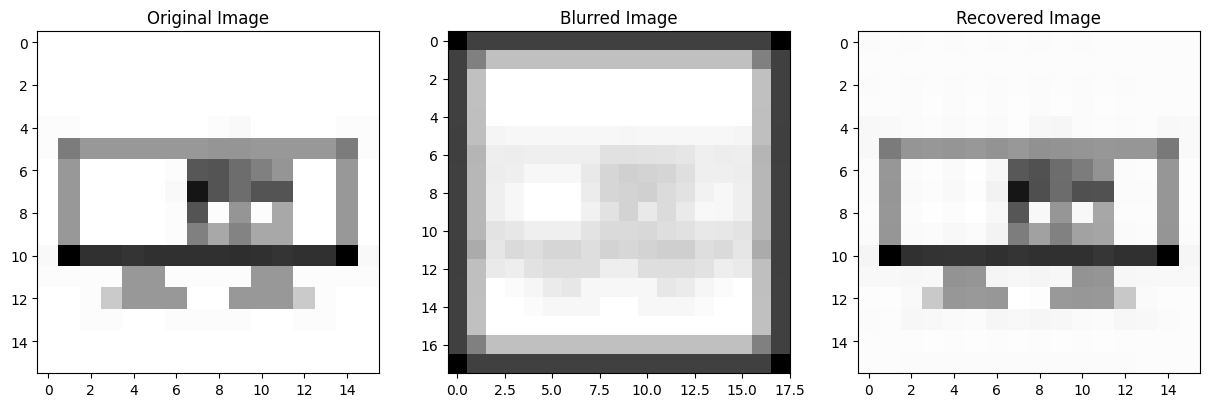

In [ ]:
h2 = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

y2 = convolve2d(img2, h2, mode='full')

recovered = K @ y2.flatten()
recovered = recovered.reshape(img2.shape)

# plot original, blurred and recovered
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img2, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(y2, cmap='gray')
axs[1].set_title('Blurred Image')

axs[2].imshow(recovered, cmap='gray')
axs[2].set_title('Recovered Image')
plt.show()

In [ ]:
import cv2
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from scipy.linalg import toeplitz
from scipy.signal import convolve

import numpy as np
from scipy.signal import convolve2d
from scipy.linalg import circulant

def build_H_2d_from_h(h, input_shape):
    """
    Constructs the 2D convolution matrix H for kernel h and input shape.
    This results in a matrix H such that H @ x.flatten() ≈ y.flatten()
    """
    h_height, h_width = h.shape
    in_height, in_width = input_shape
    out_height = in_height + h_height - 1
    out_width = in_width + h_width - 1

    H_rows = out_height * out_width
    H_cols = in_height * in_width
    H = np.zeros((H_rows, H_cols))

    # Impulse basis for each pixel in x
    for i in range(in_height):
        for j in range(in_width):
            impulse = np.zeros(input_shape)
            impulse[i, j] = 1.0
            conv_result = convolve2d(impulse, h, mode='full')
            H[:, i * in_width + j] = conv_result.flatten()

    return H

def precompute_deconv_operator_2d(h, input_shape, delta=1e-3):
    """
    Precomputes the 2D deconvolution operator K = (HᵀH + δI)^(-1) Hᵀ
    """
    H = build_H_2d_from_h(h, input_shape)
    HtH = H.T @ H
    reg = delta * np.eye(HtH.shape[0])
    K = np.linalg.inv(HtH + reg) @ H.T
    return K

k = np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]])
K_16 = precompute_deconv_operator_2d(k, (32, 32))
K_16.shape

(1024, 1156)

In [ ]:


# x is a 5x5 image
# x = np.array([[1, 2, 3, 4, 5],
#               [6, 7, 8, 9, 10],
#               [11, 12, 13, 14, 15],
#               [16, 17, 18, 19, 20],
#               [21, 22, 23, 24, 25]])
x = np.arange(36).reshape(6, 6)

print("x: \n", x)
print()

# k = 3x3 blur kernel
k = np.array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]])
# k = np.array([[0, 1, 0],
#               [1, 0, 1],
#               [0, 1, 0]])
# K_16 = precompute_deconv_operator_2d(k, (16, 16))

# y is the blurred image
y = convolve2d(x, k, mode='same')

print(y)

x1 = x[:3, :3]
print("x1: \n", x1)

y1 = convolve2d(x1, k, mode='full')
print("y1: \n", y1)

recovered = K_6 @ y1.flatten()
recovered = recovered.reshape(x1.shape)
print("recovered: \n", np.round(recovered))

y_ = y[:3, :3]
y_ = np.pad(y_, ((1, 1), (1, 1)), mode='constant')
print("y_: \n", y_)

recovered_ = K_6 @ y_.flatten()
recovered_ = recovered_.reshape(x1.shape)
print("recovered_: \n", np.round(recovered_))


x2 = x[:3, 1:4]
print("x2: \n", x2)

y2 = convolve2d(x2, k, mode='full')
print("y2: \n", y2)

recovered2 = K_6 @ y2.flatten()
recovered2 = recovered2.reshape(x2.shape)
print("recovered: \n", np.round(recovered2))

x3 = x[:3, 2:5]
print("x3: \n", x3)

y3 = convolve2d(x3, k, mode='same')
print("y3: \n", y3)

x: 
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
x1: 
 [[ 0  1  2]
 [ 6  7  8]
 [12 13 14]]
y1: 
 [[ 0  0  0  0  0]
 [ 0  0  1  2  0]
 [ 0  6  7  8  0]
 [ 0 12 13 14  0]
 [ 0  0  0  0  0]]
recovered: 
 [[-2. -2. -1.]
 [ 2.  7.  3.]
 [ 1.  6.  2.]]
y_: 
 [[ 0  0  0  0  0]
 [ 0  0  1  2  0]
 [ 0  6  7  8  0]
 [ 0 12 13 14  0]
 [ 0  0  0  0  0]]
recovered_: 
 [[-2. -2. -1.]
 [ 2.  7.  3.]
 [ 1.  6.  2.]]
x2: 
 [[ 1  2  3]
 [ 7  8  9]
 [13 14 15]]
y2: 
 [[ 0  0  0  0  0]
 [ 0  1  2  3  0]
 [ 0  7  8  9  0]
 [ 0 13 14 15  0]
 [ 0  0  0  0  0]]
recovered: 
 [[-2. -1. -1.]
 [ 2.  8.  3.]
 [ 1.  7.  2.]]
x3: 
 [[ 2  3  4]
 [ 8  9 10]
 [14 15 16]]
y3: 
 [[ 2  3  4]
 [ 8  9 10]
 [14 15 16]]


In [2]:
import numpy as np
from scipy.signal import convolve2d
from scipy.linalg import circulant

def build_H_2d_from_h(h, input_shape):
    """
    Constructs the 2D convolution matrix H for kernel h and input shape.
    This results in a matrix H such that H @ x.flatten() ≈ y.flatten()
    """
    h_height, h_width = h.shape
    in_height, in_width = input_shape
    out_height = in_height + h_height - 1
    out_width = in_width + h_width - 1

    H_rows = out_height * out_width
    H_cols = in_height * in_width
    H = np.zeros((H_rows, H_cols))

    # Impulse basis for each pixel in x
    for i in range(in_height):
        for j in range(in_width):
            impulse = np.zeros(input_shape)
            impulse[i, j] = 1.0
            conv_result = convolve2d(impulse, h, mode='full')
            H[:, i * in_width + j] = conv_result.flatten()

    return H

def precompute_deconv_operator_2d(h, input_shape, delta=1e-3):
    """
    Precomputes the 2D deconvolution operator K = (HᵀH + δI)^(-1) Hᵀ
    """
    H = build_H_2d_from_h(h, input_shape)
    HtH = H.T @ H
    reg = delta * np.eye(HtH.shape[0])
    K = np.linalg.inv(HtH + reg) @ H.T
    return K


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

In [4]:
#!/bin/bash
!curl -L -o sprites-16x16-dataset.zip https://www.kaggle.com/api/v1/datasets/download/bajajganesh/sprites-16x16-dataset
!unzip sprites-16x16-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19.7M  100 19.7M    0     0  10.3M      0  0:00:01  0:00:01 --:--:-- 34.5M
Archive:  sprites-16x16-dataset.zip
  inflating: sprite_labels_nc_1788_16x16.npy  
  inflating: sprites_1788_16x16.npy  


sprite_labels shape: (89400, 5)
sprites shape: (89400, 16, 16)


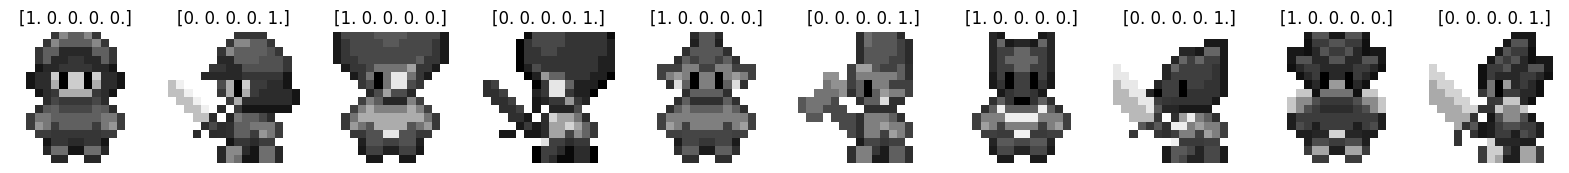

In [5]:
# data
sprite_labels = np.load("/content/sprite_labels_nc_1788_16x16.npy")
sprites       = np.load("/content/sprites_1788_16x16.npy")

# convert sprites to greyscale
sprites = np.dot(sprites[..., :3], [0.2989, 0.5870, 0.1140])  # shape: (N, 16, 16)

# explore
print("sprite_labels shape:", sprite_labels.shape)
print("sprites shape:", sprites.shape)

# plot
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

for i in range(10):
    axs[i].imshow(sprites[i], cmap='gray')
    axs[i].set_title(f'{sprite_labels[i]}')
    axs[i].axis('off')

plt.show()



In [ ]:
sprites[52]

array([[254.9745, 254.9745, 254.9745, 254.9745,  37.9962,  24.9975,
         85.6098, 171.8066, 171.8066,  85.6098,  24.9975,  37.9962,
        254.9745, 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, 254.9745,  37.9962, 101.9898,
         64.0294, 171.8066, 171.8066,  64.0294, 101.9898,  37.9962,
        254.9745, 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, 254.9745,  37.9962,  62.9937,
        171.8066, 171.8066, 171.8066, 171.8066,  62.9937,  37.9962,
        254.9745, 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, 254.9745,  37.9962,  62.9937,
        128.9447, 171.8066, 171.8066, 128.9447,  62.9937,  37.9962,
        254.9745, 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, 254.9745,  37.9962,  62.9937,
         62.9937, 128.9447, 128.9447,  62.9937,  62.9937,  37.9962,
        254.9745, 254.9745, 254.9745, 254.9745],
       [254.9745, 254.9745, 254.9745, 254.9745, 130.7383,  62.9937,
       

In [ ]:
temp_img = sprites[52]
temp_img_64 = (temp_img * (2 / 255)).astype(int)
temp_img_64.min(), temp_img_64.max()

(np.int64(0), np.int64(1))

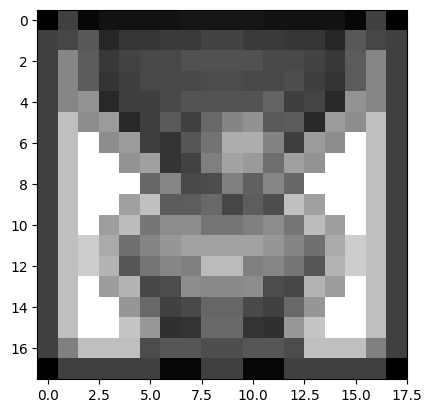

In [ ]:
h = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

temp_img = sprites[52]
blurred_img = convolve2d(temp_img, h, mode='full')
norm = (blurred_img - blurred_img.min()) / (blurred_img.max() - blurred_img.min())
clipped = (norm * 255).round()
plt.imshow
plt.imshow(clipped, cmap='gray')
plt.show()

intfkingger = np.round(clipped.flatten()).astype(int)
#save blurred image to txt file pixel by pixel
np.savetxt('blurred_img.txt', intfkingger, fmt='%s')


In [ ]:
K0.shape

(256, 324)

In [ ]:
clipped.shape

(18, 18)

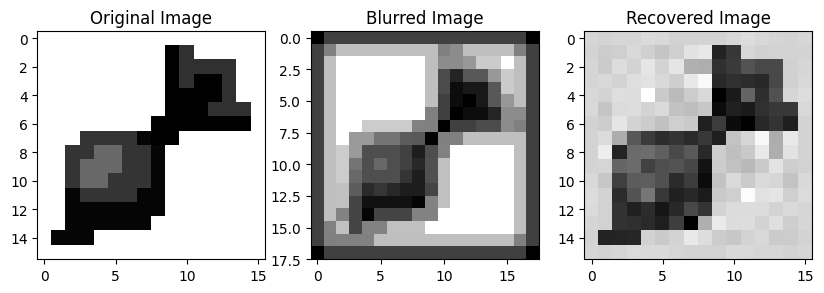

In [41]:
h = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

K0 = precompute_deconv_operator_2d(h, (16, 16))

temp_img = sprites[230]
temp_img_norm = (temp_img - temp_img.min()) / (temp_img.max() - temp_img.min())
temp_img_norm = (temp_img_norm * 255).round()

blurred_img = convolve2d(temp_img_norm, h, mode='full')
blurred_img_norm = (blurred_img - blurred_img.min()) / (blurred_img.max() - blurred_img.min())
blurred_img_norm = (blurred_img_norm * 255).round()

recovered_img = np.round(K0, 2)*10 @ blurred_img_norm.flatten()
recovered_img = recovered_img.reshape(temp_img.shape)

# plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(temp_img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(blurred_img_norm, cmap='gray')
axs[1].set_title('Blurred Image')
axs[2].imshow(recovered_img, cmap='gray')
axs[2].set_title('Recovered Image')

plt.show()

# save into files
np.savetxt('original_img.txt', temp_img.flatten(), fmt='%d')
np.savetxt('blurred_img.txt', blurred_img_norm.flatten(), fmt='%d')


# save PNGs
plt.imsave('original.png',    temp_img,         cmap='gray')
plt.imsave('blurred.png',     blurred_img_norm, cmap='gray')
plt.imsave('recovered.png',   recovered_img,    cmap='gray')



In [ ]:
h.shape

AttributeError: 'int' object has no attribute 'shape'

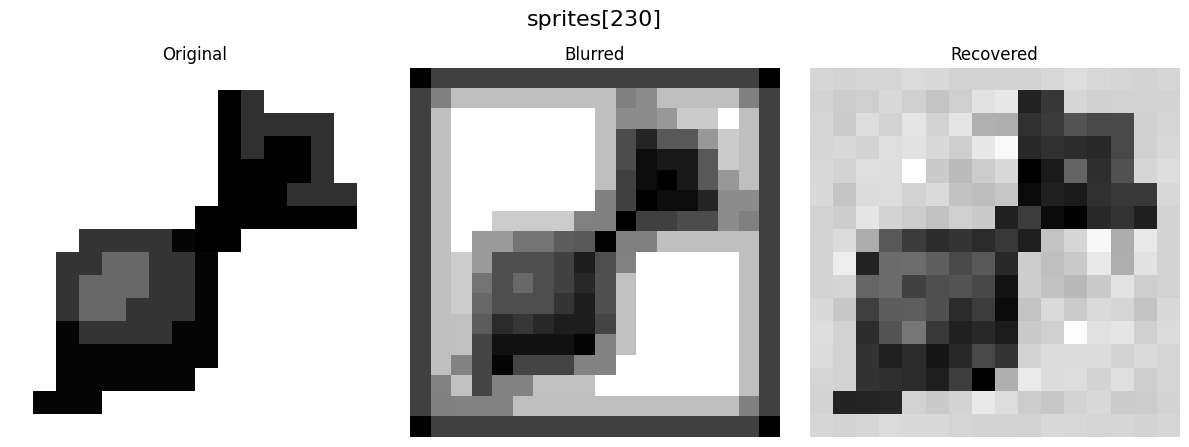












PSNR: -1.9593291993095505
PSNR for blurred image: 8.800643486096469


In [42]:
import matplotlib.pyplot as plt

# assume sprites is your list and sprites[52] is the name you want
title = "sprites[230]"

fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# list of (image, subplot title)
imgs = [
    (temp_img_norm,   'Original'),
    (blurred_img_norm,'Blurred'),
    (recovered_img,   'Recovered')
]

for ax, (im, t) in zip(axs, imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(t, fontsize=12)

# set a suptitle for the entire figure
fig.suptitle(title, fontsize=16, y=1.08)

plt.show()


print("\n"*10)

# print psnr from mse
mse = np.mean((temp_img_norm - recovered_img) ** 2)
psnr = 10 * np.log10(255**2 / mse)
print("PSNR:", psnr)

# print psnr from mse for blurred image
mse = np.mean((padded - blurred_img_norm) ** 2)
psnr = 10 * np.log10(255**2 / mse)
print("PSNR for blurred image:", psnr)


(16, 16)

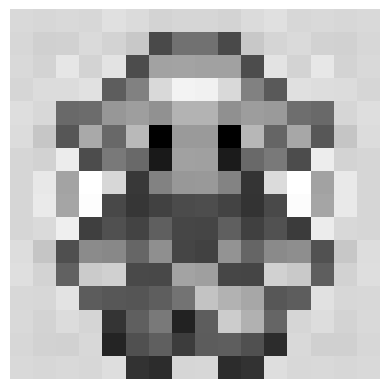

In [24]:
h1 = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

pad = 1
h, w = temp_img_norm.shape
# make a 20×20 canvas

padded = np.zeros((h + 2*pad, w + 2*pad), dtype=temp_img_norm.dtype)
# copy the 16×16 image into its center
padded[pad:pad+h, pad:pad+w] = temp_img_norm
plt.imshow(recovered_img, cmap='grey')
plt.axis("off")

blurred1 = convolve2d(padded, h1, mode='valid')
blurred1.shape

In [ ]:
blurred1.min(), blurred1.max()

(np.float64(0.0), np.float64(1020.0))

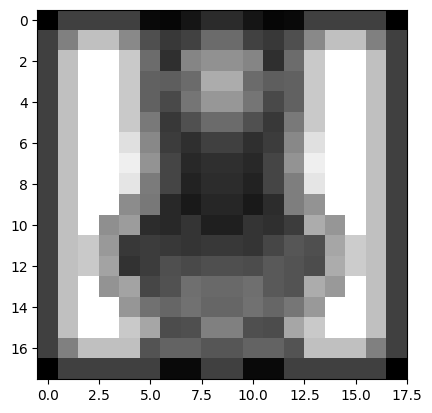

In [ ]:
plt.imshow(blurred1, cmap='gray')
plt.show()

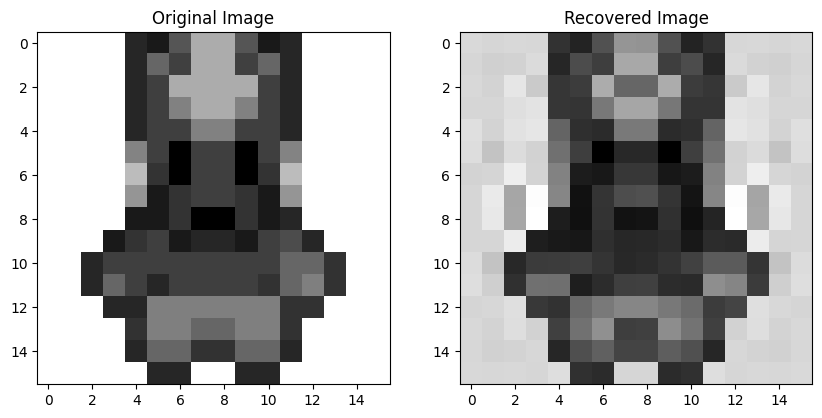

In [ ]:
blurred1_norm = (blurred1 - blurred1.min()) / (blurred1.max() - blurred1.min())
blurred1_norm = (blurred1_norm * 255).round()

recovered_img = np.round(K0, 2)*10 @ blurred1_norm.flatten()
recovered_img = recovered_img.reshape(temp_img.shape)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(temp_img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(recovered_img, cmap='gray')
axs[1].set_title('Recovered Image')

plt.show()

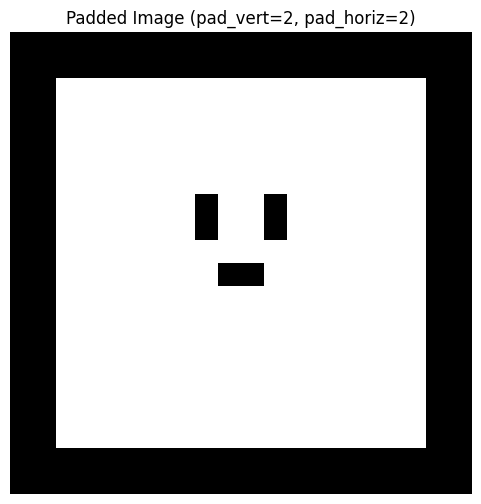

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# assume temp_img_norm is your 2D array and h is your kernel

# 1) Compute how much padding "full" adds:
pad_vert = h.shape[0] - 1
pad_horiz = h.shape[1] - 1

# 2) Manually zero‑pad (same on all sides):
padded = np.pad(
    temp_img_norm,
    ((pad_vert, pad_vert), (pad_horiz, pad_horiz)),
    mode='constant',
    constant_values=0
)

# 3) You can now visualize that padded image:
plt.figure(figsize=(6,6))
plt.imshow(padded, cmap='gray', vmin=0, vmax=1)
plt.title(f"Padded Image (pad_vert={pad_vert}, pad_horiz={pad_horiz})")
plt.axis('off')
plt.show()

# 4) And if you convolve that with 'valid' you’ll reproduce your original 'full' result:
reconstructed_full = convolve2d(padded, h, mode='valid')
assert np.allclose(reconstructed_full, convolve2d(temp_img_norm, h, mode='full'))


In [ ]:
blurred_img_norm[]

array([[  0.,  64.,  64.,  64.,  64.,  10.,   6.,  22.,  43.,  43.,  22.,
          6.,  10.,  64.,  64.,  64.,  64.,   0.],
       [ 64., 128., 191., 191., 137.,  80.,  56.,  65., 108., 108.,  65.,
         56.,  80., 137., 191., 191., 128.,  64.],
       [ 64., 191., 255., 255., 201., 108.,  48., 133., 145., 145., 133.,
         48., 108., 201., 255., 255., 191.,  64.],
       [ 64., 191., 255., 255., 201.,  98.,  94., 107., 172., 172., 107.,
         94.,  98., 201., 255., 255., 191.,  64.],
       [ 64., 191., 255., 255., 201.,  98.,  73., 118., 150., 150., 118.,
         73.,  98., 201., 255., 255., 191.,  64.],
       [ 64., 191., 255., 255., 201., 122.,  57.,  80., 107., 107.,  80.,
         57., 122., 201., 255., 255., 191.,  64.],
       [ 64., 191., 255., 255., 224., 136.,  61.,  47.,  64.,  64.,  47.,
         61., 136., 224., 255., 255., 191.,  64.],
       [ 64., 191., 255., 255., 238., 146.,  69.,  41.,  47.,  47.,  41.,
         69., 146., 238., 255., 255., 191.,  64.],


blurred iamge shape:  (18, 18)


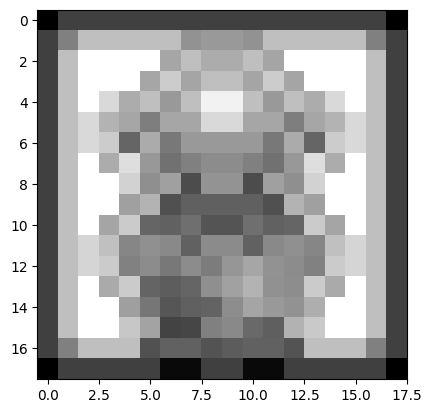

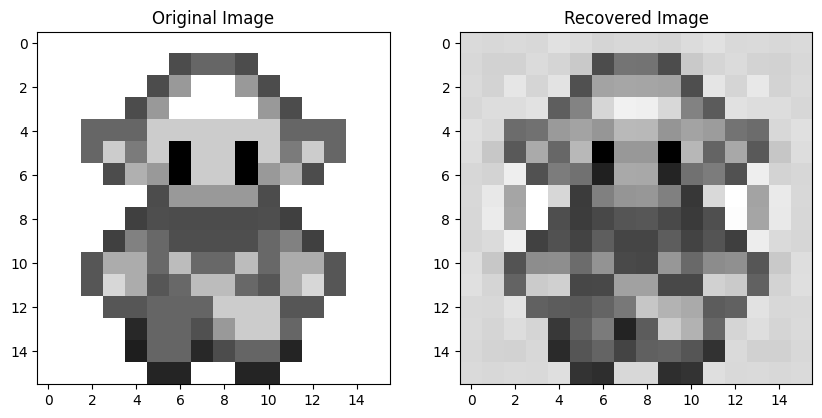

In [ ]:
h = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)

K0 = precompute_deconv_operator_2d(h, (16, 16))

temp_img = sprites[56]
blurred_img = convolve2d(temp_img, h, mode='full')
blurred_img[-1][-1] = 0
print("blurred iamge shape: ", blurred_img.shape)
norm = (blurred_img - blurred_img.min()) / (blurred_img.max() - blurred_img.min())
clipped = (norm * 255).round()
plt.imshow(clipped, cmap='gray')
plt.show()

recovered_img = np.round(K0, 2)*10 @ clipped.flatten()
recovered_img = recovered_img.reshape(temp_img.shape)

# plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(temp_img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow()
axs[2].imshow(recovered_img, cmap='gray')
axs[2].set_title('Recovered Image')

plt.show()

In [ ]:
recovered_img

array([[639.7, 633. , 639.2, 635.8, 113.2,  67. , 203.6, 424.7, 424.3,
        204. ,  66.6, 113.4, 636.1, 639.6, 633. , 639.7],
       [633.6, 612.3, 619.5, 646.2,  74.9, 206.4, 149.1, 486.1, 485.4,
        150.1, 205.3,  75.5, 644.4, 619.2, 612.3, 634.2],
       [640.1, 624. , 680.7, 593.3, 120.3, 151.9, 496.7, 283.9, 281.4,
        499.2, 149.9, 123.6, 595.7, 681.7, 623.4, 639.7],
       [630.1, 631.6, 658.1, 676.7, 124. , 124.5, 329.7, 479.2, 476.5,
        330.7, 117.8, 122.8, 676.6, 660.1, 632.4, 629.7],
       [660.4, 624.1, 667.8, 684.3, 271.5, 107.6,  86.3, 341.7, 340.4,
         90.2, 107.9, 276.8, 682.9, 666. , 625.5, 660.2],
       [651.4, 575. , 648. , 615.4, 305.9, 156.5, -46.3,  88.7,  86.2,
        -45.1, 152.9, 308.7, 614.3, 643.1, 573.6, 651. ],
       [625.4, 631.7, 710.2, 631.7, 367.7,  47.3,  30. , 126.4, 128. ,
         31.8,  43.5, 369.1, 636.3, 712.9, 635.8, 626.8],
       [631.6, 692.5, 473.7, 754. , 375.2,   7.6, 121.6, 200.4, 209.1,
        126.1,  12.3, 373.

In [ ]:
K0.shape

(256, 324)

In [ ]:
K0.min(), K0.max()

(np.float64(-0.7005440643647695), np.float64(0.7933494100502058))

In [ ]:
(K0*100).min(), (K0*100).max()

(np.float64(-70.05440643647695), np.float64(79.33494100502058))

In [ ]:
recovered_img.min(), recovered_img.max()

(np.float64(-1.41996662776873), np.float64(64.77213809380382))

In [ ]:
np.savetxt('blurred_img.txt', np.round(clipped_flat), fmt='%s')


In [ ]:
K_scaled = np.round(K0, 2) * 100
K_int    = K_scaled.astype(int)
K0_flat = K0.flatten()
# K0_flat *= 0
# K0_flat += 1
clipped_flat = clipped.flatten()
# clipped_flat *= 0
# clipped_flat += 2
print(K0.flatten().shape)        # 82944 <- (256x324)
print(clipped_flat.shape)   # 324

# matrix multiply
import numpy as np

m = 256
n = 324

y = np.zeros(m, dtype=K0_flat.dtype)

for i in range(m):
    base = i * n
    # compute dot product of the i-th row
    y[i] = np.round(np.dot(K0_flat[base : base + n], clipped_flat))
    # if i == 1:
      # break

# y now has shape (256,)


(82944,)
(324,)


In [ ]:
for i in range(255):
    clipped_flat[i] = i+1

In [ ]:
clipped_flat

array([  0.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,  64.,
        64.,  64.,  64.,  64.,  64.,  64.,   0.,  64., 128., 191., 191.,
       191., 191., 191., 146., 153., 153., 146., 191., 191., 191., 191.,
       191., 128.,  64.,  64., 191., 255., 255., 255., 255., 166., 191.,
       172., 172., 191., 165., 255., 255., 255., 255., 191.,  64.,  64.,
       191., 255., 255., 255., 166., 204., 165., 191., 191., 165., 204.,
       165., 255., 255., 255., 191.,  64.,  64., 191., 255., 217., 172.,
       191., 153., 191., 242., 242., 191., 153., 191., 172., 217., 255.,
       191.,  64.,  64., 191., 217., 179., 166., 126., 166., 166., 217.,
       217., 166., 166., 126., 166., 179., 217., 191.,  64.,  64., 191.,
       217., 204., 101., 171., 120., 153., 153., 153., 153., 120., 171.,
       101., 204., 217., 191.,  64.,  64., 191., 255., 172., 222., 152.,
       114., 128., 140., 140., 128., 114., 152., 222., 172., 255., 191.,
        64.,  64., 191., 255., 255., 210., 143., 16

In [ ]:
K0_flat = K0_flat*100

In [ ]:
K0_flat = np.round(K0_flat)

In [ ]:
K0_flat

array([ 0., 47.,  0., ...,  0., 47.,  0.])

In [ ]:
K0_flat.min(), K0_flat.max()

(np.float64(-70.0), np.float64(79.0))

In [ ]:
if K0_flat.min() < 0:
  shift_val = -K0_flat.min()  # This makes the minimum value 0
  shifted_K0_flat = K0_flat + shift_val

In [ ]:
shifted_K0_flat.min(), shifted_K0_flat.max()

(np.float64(0.0), np.float64(149.0))

In [ ]:
shifted_K0_flat

array([ 70., 117.,  70., ...,  70., 117.,  70.])

In [ ]:
sum(shifted_K0_flat[1:15])

np.float64(1027.0)

In [ ]:
np.sum

In [ ]:
correction = shift_val * clipped_flat.sum()
correction

np.float64(3377640.0)

In [ ]:
correction = shift_val_f * clipped_flat.sum()
correction

np.float64(3377640.0)

In [ ]:
final_result = result - correction


In [ ]:
sum(clipped_flat)

np.float64(324.0)

In [ ]:
bin(82620)

'0b10100001010111100'

In [ ]:
clipped_flat.min()

np.float64(0.0)

In [ ]:
np.dot(shifted_K0_flat[324:324*2], clipped_flat)

np.float64(22746.0)

In [ ]:
shifted_K0_flat[-1]

np.float64(70.0)

In [ ]:
70*64

4480

In [ ]:
117*64

7488

In [ ]:
shifted_K0_flat.min(), shifted_K0_flat.max()

(np.float64(0.0), np.float64(149.0))

In [ ]:
bin(255)

'0b11111111'

In [ ]:
clipped_flat

array([  0.,  64.,  64.,  64.,  64.,  10.,   6.,  21.,  43.,  43.,  21.,
         6.,  10.,  64.,  64.,  64.,  64.,   0.,  64., 128., 191., 191.,
       137.,  80.,  56.,  65., 107., 107.,  65.,  56.,  80., 137., 191.,
       191., 128.,  64.,  64., 191., 255., 255., 201., 108.,  48., 133.,
       145., 145., 133.,  48., 108., 201., 255., 255., 191.,  64.,  64.,
       191., 255., 255., 201.,  98.,  94., 107., 172., 172., 107.,  94.,
        98., 201., 255., 255., 191.,  64.,  64., 191., 255., 255., 201.,
        98.,  73., 117., 150., 150., 117.,  73.,  98., 201., 255., 255.,
       191.,  64.,  64., 191., 255., 255., 201., 122.,  57.,  80., 107.,
       107.,  80.,  57., 122., 201., 255., 255., 191.,  64.,  64., 191.,
       255., 255., 224., 136.,  61.,  47.,  64.,  64.,  47.,  61., 136.,
       224., 255., 255., 191.,  64.,  64., 191., 255., 255., 238., 146.,
        69.,  41.,  47.,  47.,  41.,  69., 146., 238., 255., 255., 191.,
        64.,  64., 191., 255., 255., 229., 123.,  6

In [ ]:
# save clipped_flat to txt
np.savetxt("blurred_img.txt", clipped_flat, fmt='%d')

In [ ]:
m = 256
n = 324

y = np.zeros(m, dtype=K0_flat.dtype)

for i in range(m):
    base = i * n
    # compute dot product of the i-th row
    y[i] = np.round(np.dot(shifted_K0_flat[base : base + n], clipped_flat))


In [ ]:
y


array([3384028., 3383976., 3384035., 3383988., 3384267., 3384111.,
       3383896., 3383976., 3383976., 3383896., 3384111., 3384268.,
       3383996., 3384035., 3383972., 3384028., 3383976., 3383777.,
       3383793., 3384066., 3383895., 3383501., 3379443., 3380727.,
       3380718., 3379442., 3383500., 3383880., 3384064., 3383819.,
       3383777., 3383978., 3384038., 3383842., 3384448., 3383867.,
       3384362., 3379590., 3382292., 3382359., 3382319., 3382275.,
       3379519., 3384390., 3383892., 3384501., 3383844., 3384038.,
       3383948., 3384141., 3384145., 3384300., 3380031., 3381225.,
       3383907., 3384802., 3384737., 3383970., 3381206., 3379937.,
       3384263., 3384142., 3384136., 3383942., 3384217., 3384023.,
       3380479., 3380641., 3381963., 3382307., 3381852., 3382975.,
       3382938., 3381817., 3382271., 3382036., 3380711., 3380494.,
       3383967., 3384223., 3384140., 3383419., 3379892., 3382487.,
       3380316., 3382948., 3376969., 3381914., 3381898., 33769

In [ ]:
bin(68)

In [ ]:
print(bin(-48252))
number = f"{48252:032b}"
# number = "11111111111111110100001110000011"
print(number[24:32])
print(number[16:24])
print(number[8:16])
print(number[0:8])

print(int(number[24:32], 2))
print(int(number[16:24], 2))
print(int(number[8:16], 2))
print(int(number[0:8], 2))

print(f"{-48252:032b}")

-0b1011110001111100
01111100
10111100
00000000
00000000
124
188
0
0
-0000000000000001011110001111100


In [ ]:
print(int("0b11111111111111110100001110000011", 2))

4294919043


In [ ]:
print(int('0b10111100', 2))

188


In [ ]:
group1 = [0, 51, 180 , 99]
binstring = ''.join(format(int(val) & 0xFF, '08b') for val in group1)
print(int(binstring, 2))

3388515


In [ ]:
3388456 - 3383976

4480

In [ ]:
3388515 - 3384035

4480

In [ ]:
2857202 - 2852722

4480

In [ ]:
2862428 - 2857948

4480

In [ ]:
2862400 - 2857920


4480

In [ ]:
2862462 - 2857982

4480

In [ ]:
# 22774., 22746., 22773., 22760
#         22676., 22703.
#            70.,  70.
2857920 - 2856324

1596

In [ ]:
2857982 - 2859006

-1024

In [ ]:
 2859006 - 2857982

1024

In [ ]:
# 3386524 - 3377640
2857982 - 2859006

-1024

In [ ]:
recovered_img

array([[638.8, 633.6, 639.5, 634.8, 662.7, 647.1, 625.6, 633.6, 633.6,
        625.6, 647.1, 662.8, 635.6, 639.5, 633.2, 638.8],
       [633.6, 613.7, 615.3, 642.6, 625.5, 586.1, 180.3, 308.7, 307.8,
        180.2, 586. , 624. , 642.4, 617.9, 613.7, 633.8],
       [639.8, 620.2, 680.8, 622.7, 672.2, 195. , 465.2, 471.9, 467.9,
        463.5, 187.9, 675. , 625.2, 686.1, 620.4, 639.8],
       [630.8, 650.1, 650.5, 666. , 239.1, 358.5, 626.7, 716.2, 709.7,
        633. , 356.6, 229.7, 662.3, 650.2, 649.6, 630.2],
       [657.7, 638.3, 283.9, 300.1, 432.3, 466.7, 421.2, 533.5, 529.8,
        417.7, 463.1, 439.6, 307.1, 285.4, 632.7, 658.3],
       [650. , 577.9, 225.2, 484.7, 267.6, 530.8, -67.1, 427.4, 425.8,
        -67.3, 525.6, 258.1, 479.8, 224.2, 576.6, 650.8],
       [631.7, 618.6, 704.9, 195.1, 336.4, 300.9,  38.6, 480.5, 479.1,
         50.6, 303.4, 334.7, 198. , 706.3, 619.4, 630.8],
       [632.6, 685.5, 468.8, 759.6, 629.2, 124.3, 349.3, 415.6, 423.3,
        350.1, 113.1, 638.

In [ ]:
print(f"{648:032b}")

00000000000000000000001010001000


In [ ]:
int("0b00010000", 2)

16

In [ ]:
int("0b00000101", 2)

5

In [ ]:
b1 = f"{0:08b}"       # '00000000'
b2 = f"{2:08b}"     # '10001000'
b3 = f"{136:08b}"
b4 = f"{0:08b}"
combined = b1 + b2 + b3 + b4    # '0000000010001000'
result = int(combined, 2)
print(result)


165888


In [ ]:
# bin to dec 11110100
int('0b000000010000000010101100', 2)

65708

In [ ]:
y.min(), y.max()

(np.float64(-1.0), np.float64(65.0))

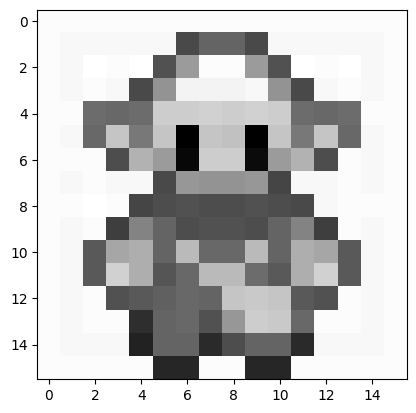

In [ ]:
plt.imshow(y.reshape(16, 16), cmap='gray')
plt.show()

In [ ]:
np.round(K0, 2)*10

array([[ 0. ,  4.7,  0. , ...,  0. , -0.3,  0. ],
       [ 0. ,  0. ,  6.2, ..., -0.2,  0. ,  0. ],
       [ 0. , -0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. , -0. ,  0. ],
       [ 0. ,  0. , -0.2, ...,  6.2,  0. ,  0. ],
       [ 0. , -0.3,  0. , ...,  0. ,  4.7,  0. ]])

In [ ]:
shifted_K0_flat[2, 3]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import numpy as np

m, n = 256, 324

# 1. Round to 2 decimals, 2. Scale by 100, 3. Cast to int16
K_int = shifted_K0_flat.astype(np.int16)

with open("h_matrix_init.v", "w") as f:
    # Declare a 16-bit signed reg array of size m*n
    f.write(f"reg signed [15:0] H_matrix [0:{m*n-1}];\n\n")
    f.write("initial begin\n")

    for idx, val in enumerate(K_int):
        f.write(f"    H_matrix[{idx}] = {val};\n")

    f.write("end\n")


In [ ]:
# log base 2
import math
math.log2(82944)

16.339850002884624

In [ ]:
intfkingger.min(), intfkingger.max()

(np.int64(269), np.int64(1020))

In [ ]:
sprites[56].min(), sprites[56].max()

(np.float64(0.0), np.float64(254.97449999999998))

In [ ]:
blurred_img.min(), blurred_img.max()

(np.float64(269.4815), np.float64(1019.8979999999999))

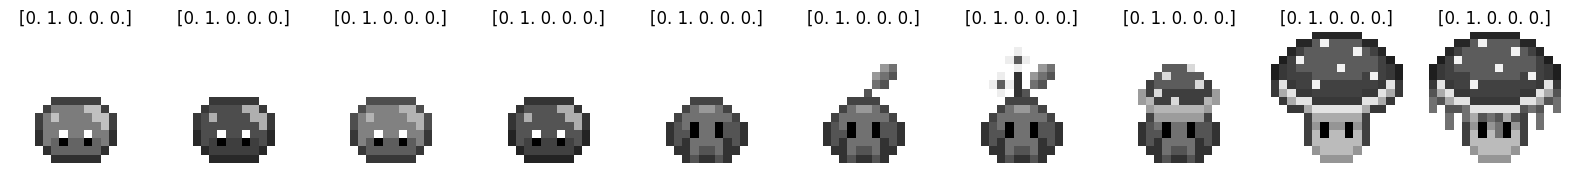

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

j = 0
for i in range(1948, 1958):  # only 10 items (1948 to 1957)
    axs[j].imshow(sprites[i], cmap='gray')
    axs[j].set_title(f'{sprite_labels[i]}')
    axs[j].axis('off')
    j += 1

plt.show()


In [ ]:
h = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).astype(np.float64)
K = precompute_deconv_operator_2d(h, (16, 16))
K0 = precompute_deconv_operator_2d(h, (16, 16))

In [ ]:
K0

array([[ 0.00000000e+00,  4.69326326e-01,  0.00000000e+00, ...,
         0.00000000e+00, -2.87348731e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.22411805e-01, ...,
        -1.97416525e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.02784705e-03,  0.00000000e+00, ...,
         0.00000000e+00,  5.88644296e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  5.88644296e-04,  0.00000000e+00, ...,
         0.00000000e+00, -1.02784705e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.97416525e-02, ...,
         6.22411805e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.87348731e-02,  0.00000000e+00, ...,
         0.00000000e+00,  4.69326326e-01,  0.00000000e+00]])

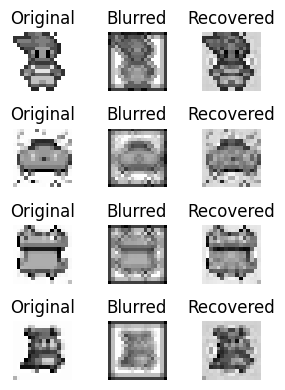

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# assume sprites is shape (N, H, W) or (N, H, W, C) already converted to grayscale
num_examples = 4
random_indices = np.random.choice(len(sprites), size=num_examples, replace=False)

fig, axs = plt.subplots(num_examples, 3, figsize=(3, 1 * num_examples))

for j, i in enumerate(random_indices):
    x_true = sprites[i]  # shape: (16, 16)
    y = convolve2d(x_true, h, mode='full')
    # add gaussian noise to y
    y = y + np.random.normal(0, 1, y.shape)
    x_hat_flat = np.round(K, 2) @ y.flatten()
    x_hat = x_hat_flat.reshape(x_true.shape)

    # Original
    axs[j, 0].imshow(x_true, cmap='gray')
    axs[j, 0].set_title(f"Original")
    axs[j, 0].axis('off')

    # Blurred
    axs[j, 1].imshow(y, cmap='gray')
    axs[j, 1].set_title("Blurred")
    axs[j, 1].axis('off')

    # Recovered
    axs[j, 2].imshow(x_hat, cmap='gray')
    axs[j, 2].set_title("Recovered")
    axs[j, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
h = np.array([[1, 1, 1, 1]]).astype(np.float64)
K = precompute_deconv_operator_2d(h, (16, 16))

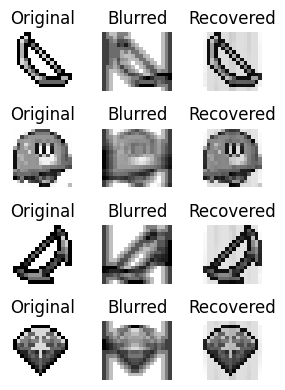

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

num_examples = 4
random_indices = np.random.choice(len(sprites), size=num_examples, replace=False)

fig, axs = plt.subplots(num_examples, 3, figsize=(3, 1 * num_examples))

for j, i in enumerate(random_indices):
    x_true = sprites[i]  # shape: (16, 16)
    y = convolve2d(x_true, h, mode='full')
    # add gaussian noise to y
    y = y + np.random.poisson(2)
    x_hat_flat = np.round(K, 2) @ y.flatten()
    x_hat = x_hat_flat.reshape(x_true.shape)

    # Original
    axs[j, 0].imshow(x_true, cmap='gray')
    axs[j, 0].set_title(f"Original")
    axs[j, 0].axis('off')

    # Blurred
    axs[j, 1].imshow(y, cmap='gray')
    axs[j, 1].set_title("Blurred")
    axs[j, 1].axis('off')

    # Recovered
    axs[j, 2].imshow(x_hat, cmap='gray')
    axs[j, 2].set_title("Recovered")
    axs[j, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
K.shape

(256, 304)

In [ ]:
K.min(), K.max()

(np.float64(-0.796379374067853), np.float64(0.844524054985149))

In [ ]:
256*304

77824

In [ ]:
y.flatten().shape

(304,)

In [ ]:
(np.round(K0, 2)*100).min(), (np.round(K0, 2)*100).max()

(np.float64(-70.0), np.float64(79.0))

In [ ]:
(np.round(K0, 2)).min(), (K0*100).max()

(np.float64(-70.05440643647695), np.float64(79.33494100502058))

In [ ]:
K_scaled = (K * 2).astype(int).clip(-8, 7)
K_scaled

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
K0

array([[ 0.00000000e+00,  4.69326326e-01,  0.00000000e+00, ...,
         0.00000000e+00, -2.87348731e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.22411805e-01, ...,
        -1.97416525e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.02784705e-03,  0.00000000e+00, ...,
         0.00000000e+00,  5.88644296e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  5.88644296e-04,  0.00000000e+00, ...,
         0.00000000e+00, -1.02784705e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.97416525e-02, ...,
         6.22411805e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.87348731e-02,  0.00000000e+00, ...,
         0.00000000e+00,  4.69326326e-01,  0.00000000e+00]])

In [ ]:
np.round(K0, 2)*100

array([[ 0., 47.,  0., ...,  0., -3.,  0.],
       [ 0.,  0., 62., ..., -2.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0., -2., ..., 62.,  0.,  0.],
       [ 0., -3.,  0., ...,  0., 47.,  0.]])

In [ ]:
if K0_flat.min() < 0:
  shift_val = -K0_flat.min()  # This makes the minimum value 0
  shifted_K0_flat = K0_flat + shift_val

In [ ]:
import numpy as np

m, n = 256, 324

# 1. Round to 2 decimals, 2. Scale by 100, 3. Cast to int
K_scaled = np.round(K0, 2) * 100
K_int    = K_scaled.astype(int)
if K_int.min() < 0:
  shift_val_f = -K_int.min()  # This makes the minimum value 0
  K_int += shift_val_f

# 4. Clip to signed-8-bit range just in case
K_int_clipped = np.clip(K_int, -128, 127)

with open("h_matrix_init.v", "w") as f:
    # Declare an 8-bit signed reg array of size m*n
    f.write(f"reg signed [7:0] H_matrix [0:{m*n-1}];\n\n")
    f.write("initial begin\n")

    idx = 0
    for i in range(m):
        for j in range(n):
            val = int(K_int_clipped[i, j])
            f.write(f"    H_matrix[{idx}] = {val};  // ({i},{j})\n")
            idx += 1

    f.write("end\n")


In [ ]:
shift_val_f

np.int64(70)

[192 184 171 109 115 107 155 160  46 215]
(256,)
Straight first 10: [         0 1936432032  785902238 4062962408  990343640 2723110718
 2870306803 1725079628 2293551138 1370871756]
Reversed first 10: [         0 2694540147 2666190638 3907136498 3631286075 1046433698
 4083619243 1285608038  584103048 3436688721]


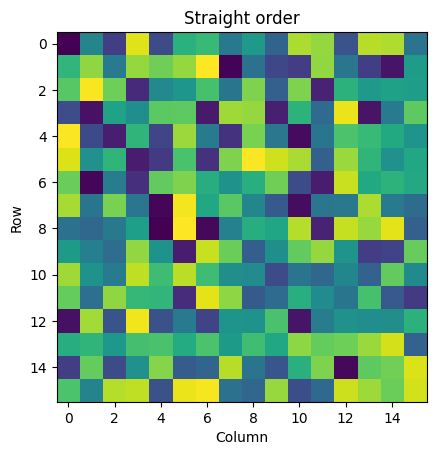

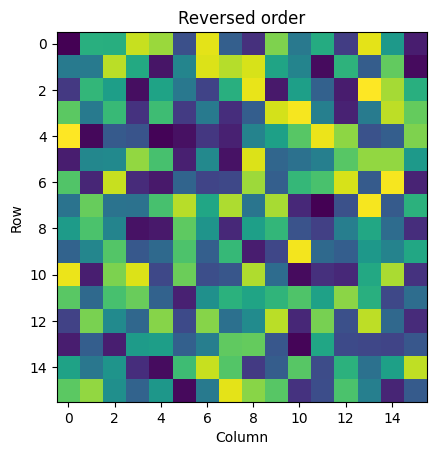

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def convert_array_to_image(arr: np.ndarray, reverse: bool = False) -> np.ndarray:
    if arr.shape[0] != 1024:
        raise ValueError("Input array must be of length 1024.")

    image = np.zeros(256, dtype=np.uint64)

    for i in range(1, 256):
        group = arr[i*4:(i+1)*4]
        if reverse:
            group = group[::-1]

        # Build the 32‑bit binary string
        binary_str = ''.join(format(int(val) & 0xFF, '08b') for val in group)
        image[i] = np.uint64(int(binary_str, 2))

    return image

# Example usage
input_array = np.array(arr)
print(input_array[:10])

# Straight order
img_straight = convert_array_to_image(input_array, reverse=False)
print(img_straight.shape)
print("Straight first 10:", img_straight[:10])

# Reversed order
img_reversed = convert_array_to_image(input_array, reverse=True)
print("Reversed first 10:", img_reversed[:10])


# plot the 256 image reshaped into 16x16
plt.imshow(img_straight.reshape(16, 16))
plt.xlabel("Column")
plt.ylabel("Row")
plt.title("Straight order")
plt.show()

plt.imshow(img_reversed.reshape(16, 16))
plt.xlabel("Column")
plt.ylabel("Row")
plt.title("Reversed order")
plt.show()

In [ ]:
bin(69)+bin(100)

'0b10001010b1100100'

In [ ]:
group1 = [0, 0, 5, 16]
binstring = ''.join(format(int(val) & 0xFF, '08b') for val in group1)
print(int(binstring, 2))

1296


In [ ]:
group1 = [0, 0, 26, 148]
binstring = ''.join(format(int(val) & 0xFF, '08b') for val in group1)
print(int(binstring, 2))

6804
